# Prior Distributions with `BILBY`

Prior distributions are a core component of any Bayesian problem and specifying them in codes can be one of the most confusing elements of a code.
The `prior` module in `BILBY` provides functionality for specifying prior distributions in a natural way.

We have a range of predefined types of prior distribution and each kind has methods to:
1. draw samples, `prior.sample`.
2. calculate the prior probability, `prior.prob`.
3. rescale samples from a unit cube to the prior distribution, `prior.rescale`.

    This is especially useful when using nested samplers as it avoids the need for rejection sampling.
4. _TODO_ calculate the log prior probability, `prior.log_prob`.

In addition to the predefined prior distributions there is functionality to specify your own prior, either from a pair of arrays, or from a file.

Each prior distribution can also be given a `name` and may have a different `latex_label` for plotting.
If no name is provided, the default is `None` (this should probably by `''`).

In [1]:
import bilby
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


## Prior Instantiation

Below we demonstrate instantiating a range of prior distributions.

Note that when a `latex_label` is not specified, the `name` is used.

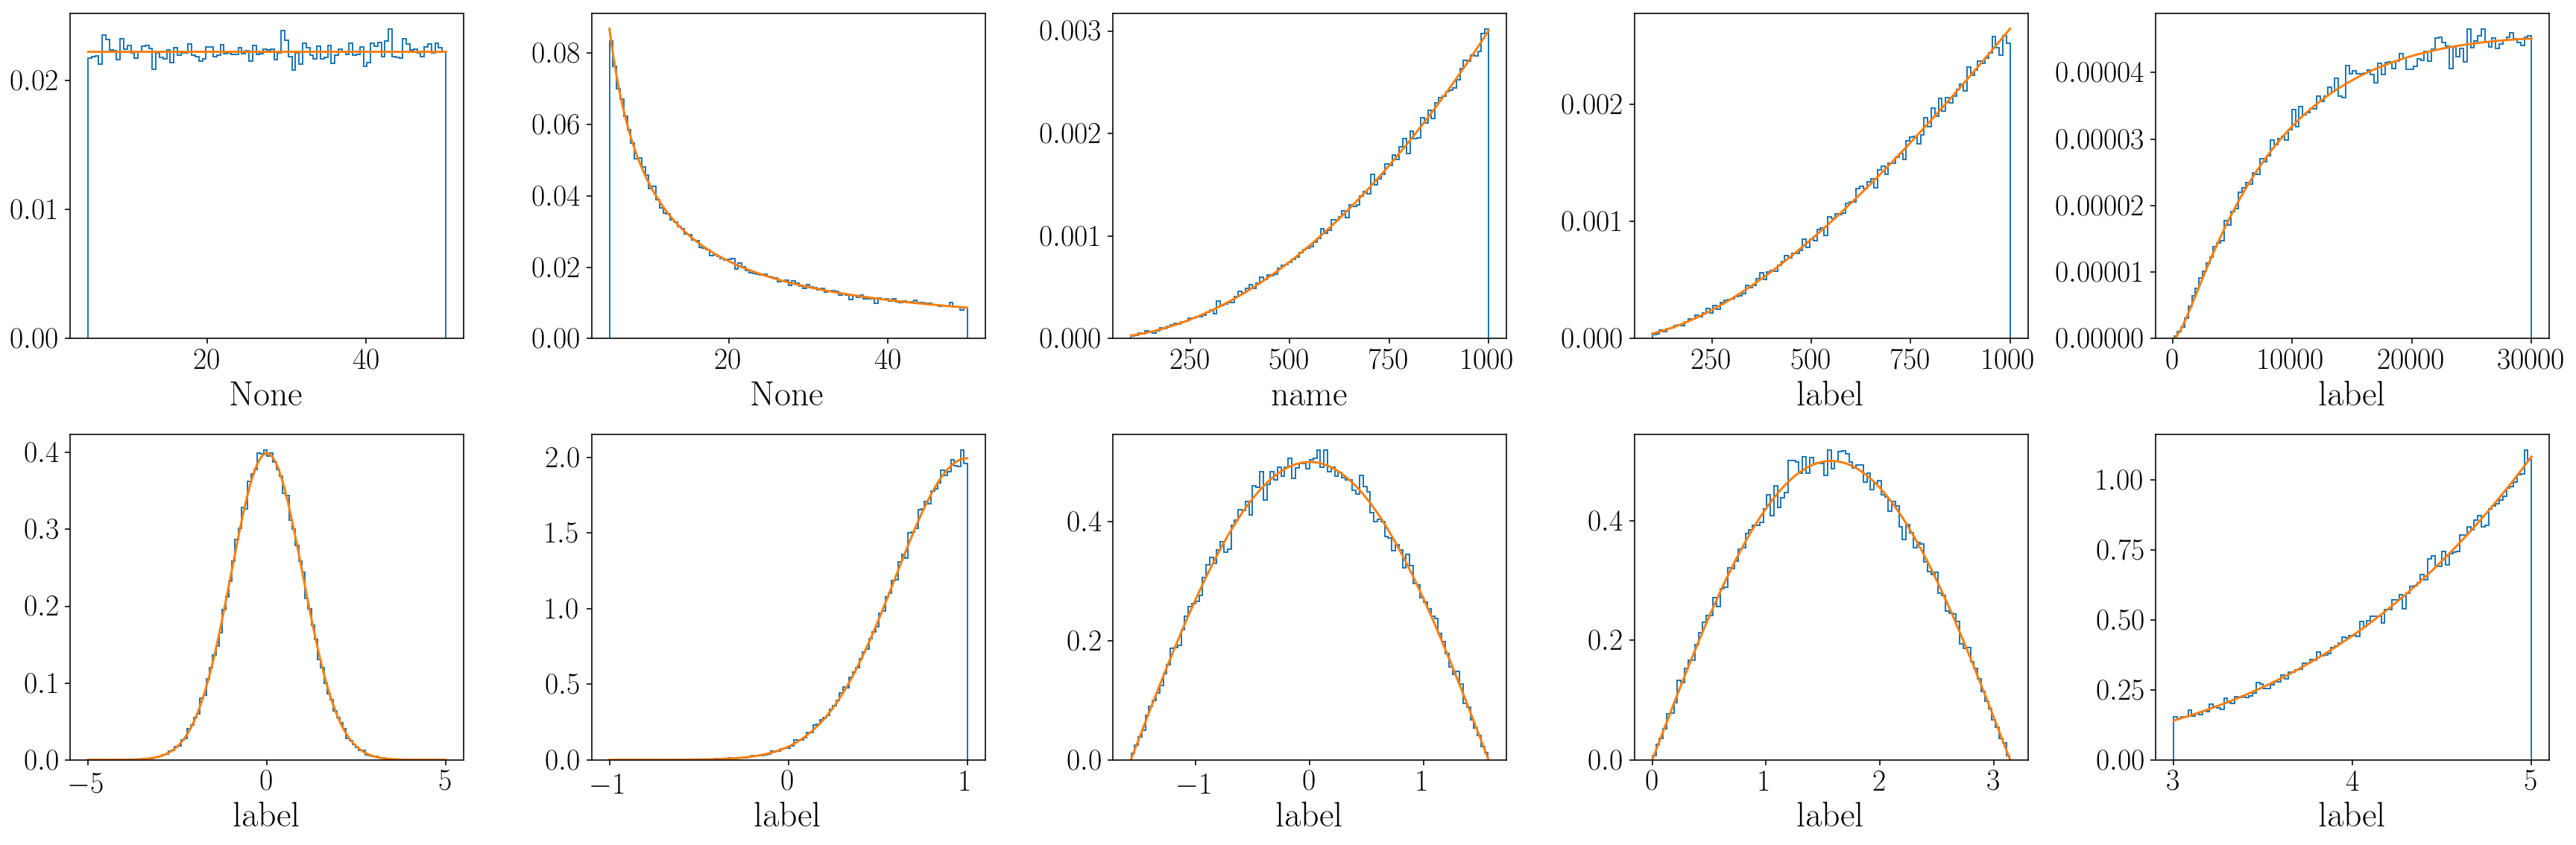

In [2]:
fig = figure(figsize=(24, 8))

priors = [
    bilby.core.prior.Uniform(minimum=5, maximum=50),
    bilby.core.prior.LogUniform(minimum=5, maximum=50),
    bilby.core.prior.PowerLaw(name='name', alpha=2, minimum=100, maximum=1000),
    bilby.core.prior.UniformComovingVolume(name='name', minimum=100, maximum=1000, latex_label='label'),
    bilby.core.prior.FromFile(name='name', file_name='comoving.txt', minimum=100, maximum=30000, latex_label='label'),
    bilby.core.prior.Gaussian(name='name', mu=0, sigma=1, latex_label='label'),
    bilby.core.prior.TruncatedGaussian(name='name', mu=1, sigma=0.4, minimum=-1, maximum=1,
                                  latex_label='label'),
    bilby.core.prior.Cosine(name='name', latex_label='label'),
    bilby.core.prior.Sine(name='name', latex_label='label'),
    bilby.core.prior.Interped(name='name', xx = np.linspace(0, 10, 1000), yy=np.linspace(0, 10, 1000)**4,
                         minimum=3, maximum=5, latex_label='label')
]

for ii, prior in enumerate(priors):
    fig.add_subplot(2, 5, 1 + ii)
    hist(prior.sample(100000), bins=100, histtype='step', normed=1)
    if not isinstance(prior, bilby.core.prior.Gaussian):
        plot(np.linspace(prior.minimum, prior.maximum, 1000),
             prior.prob(np.linspace(prior.minimum, prior.maximum, 1000)))
    else:
        plot(np.linspace(-5, 5, 1000), prior.prob(np.linspace(-5, 5, 1000)))
    xlabel('{}'.format(prior.latex_label))
    
tight_layout()
show()
close()

## Default Priors

We have a range of predefined prior distributions for common parameters, e.g., a uniform in comoving volume prior for `luminosity_distance`.

The predefined prior distributions are:

```python
'mass_1': Uniform(name='mass_1', minimum=5, maximum=100),
'mass_2': Uniform(name='mass_2', minimum=5, maximum=100),
'chirp_mass': Uniform(name='chirp_mass', minimum=5, maximum=100),
'total_mass': Uniform(name='total_mass', minimum=10, maximum=200),
'mass_ratio': Uniform(name='mass_ratio', minimum=0.125, maximum=1),
'symmetric_mass_ratio': Uniform(name='symmetric_mass_ratio', minimum=8 / 81, maximum=0.25),
'a_1': Uniform(name='a_1', minimum=0, maximum=0.8),
'a_2': Uniform(name='a_2', minimum=0, maximum=0.8),
'tilt_1': Sine(name='tilt_1'),
'tilt_2': Sine(name='tilt_2'),
'cos_tilt_1': Uniform(name='cos_tilt_1', minimum=-1, maximum=1),
'cos_tilt_2': Uniform(name='cos_tilt_2', minimum=-1, maximum=1),
'phi_12': Uniform(name='phi_12', minimum=0, maximum=2 * np.pi),
'phi_jl': Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi),
'luminosity_distance': UniformComovingVolume(name='luminosity_distance', minimum=1e2, maximum=5e3),
'dec': Cosine(name='dec'),
'ra': Uniform(name='ra', minimum=0, maximum=2 * np.pi),
'iota': Sine(name='iota'),
'cos_iota': Uniform(name='cos_iota', minimum=-1, maximum=1),
'psi': Uniform(name='psi', minimum=0, maximum=2 * np.pi),
'phase': Uniform(name='phase', minimum=0, maximum=2 * np.pi)
```

Each of these parameters has a default latex label.

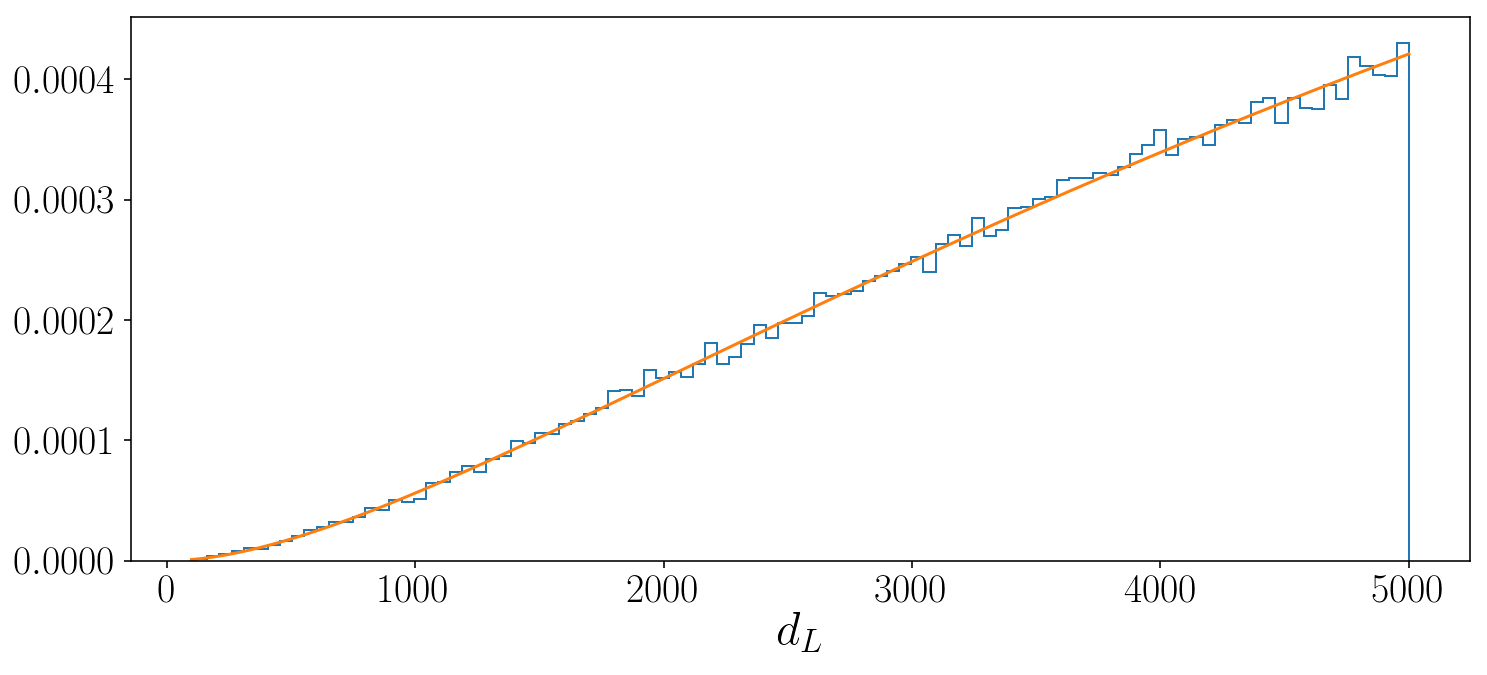

In [3]:
prior = bilby.prior.create_default_prior(name='luminosity_distance')

figure(figsize=(12, 5))
hist(prior.sample(100000), bins=100, histtype='step', normed=1)
plot(np.linspace(prior.minimum, prior.maximum, 1000), prior.prob(np.linspace(prior.minimum, prior.maximum, 1000)))
xlabel('{}'.format(prior.latex_label))
show()
close()

## Define an Analytic Prior

Adding a new analytic is achieved as follows.

In [4]:
class Exponential(bilby.prior.Prior):
    """Define a new prior class where p(x) ~ exp(alpha * x)"""
    
    def __init__(self, alpha, minimum, maximum, name=None, latex_label=None):
        bilby.prior.Prior.__init__(self, name, latex_label, minimum, maximum)
        self.alpha = alpha
        
    def rescale(self, val):
        bilby.prior.Prior.test_valid_for_rescaling(val)
        return np.log((np.exp(self.alpha * self.maximum) - np.exp(self.alpha * self.minimum)) * val
                      + np.exp(self.alpha * self.minimum)) / self.alpha
        
    def prob(self, val):
        in_prior = (val >= self.minimum) & (val <= self.maximum)
        return self.alpha * np.exp(self.alpha * val) / (np.exp(self.alpha * self.maximum)
                                                        - np.exp(self.alpha * self.minimum)) * in_prior

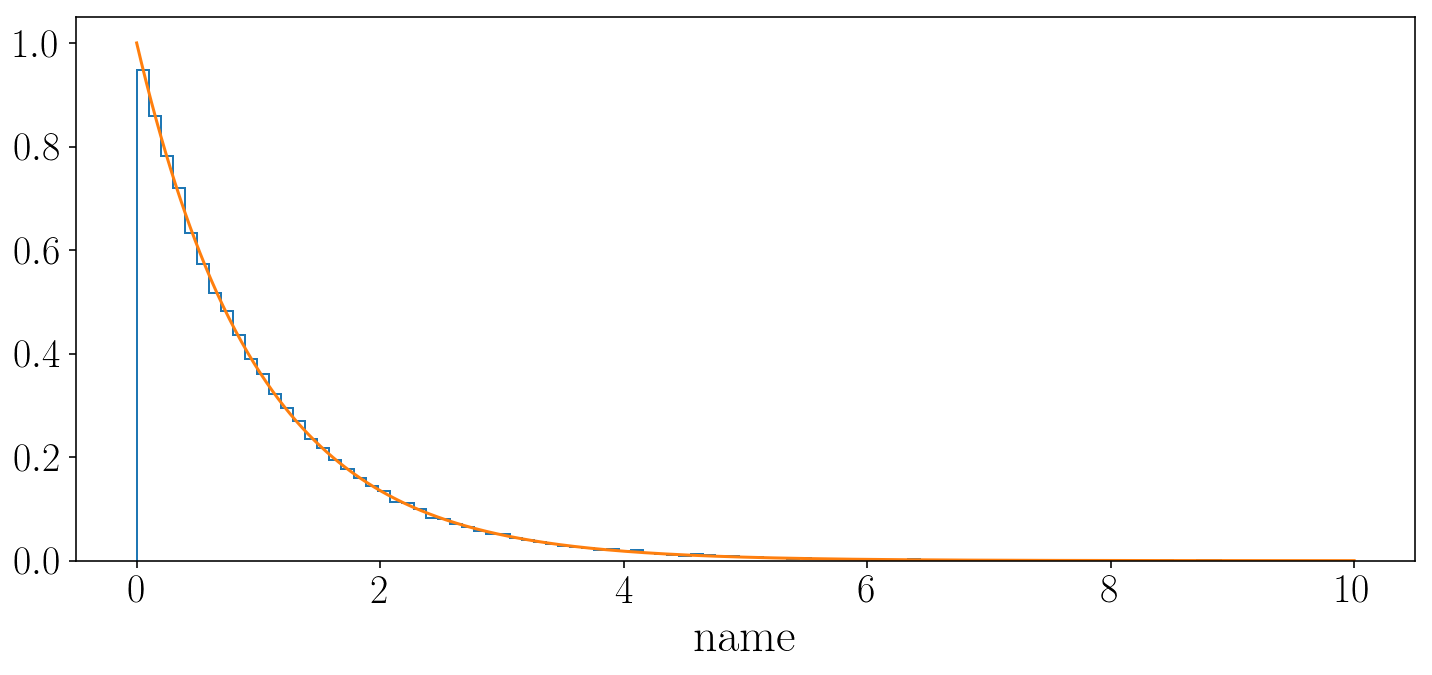

In [5]:
prior = Exponential(name='name', alpha=-1, minimum=0, maximum=10)

figure(figsize=(12, 5))
hist(prior.sample(100000), bins=100, histtype='step', normed=1)
plot(np.linspace(prior.minimum, prior.maximum, 1000), prior.prob(np.linspace(prior.minimum, prior.maximum, 1000)))
xlabel('{}'.format(prior.latex_label))
show()
close()